In [1]:
import qiskit
import numpy as np

import json, glob, math

In [2]:
glob.glob("*")

['classicalFT.py',
 'classicalFT_demo.py',
 'elephant QFT-Copy1.ipynb',
 'elephant QFT.ipynb',
 'output',
 'plotTools.py',
 'pngTools.py',
 'presentation source',
 'QHOMER_IQFT.ipynb',
 'QHOMER_Optimizer_Function_FIXED-Copy1.ipynb',
 'QHOMER_Optimizer_Function_FIXED.ipynb',
 'README.md',
 'Resources',
 'VectorQraphics.py',
 'vqe_analysis',
 '__pycache__']

In [3]:
def qubits_necessary(n):
    """log2 of n"""
    l2 = math.log2(n)
    assert l2 % 1 == 0, "not an integer power of 2"
    return int(l2)

def normalized(arr):
    """l2-normalization"""
    return arr / np.linalg.norm(arr, 2)

## Data Loading

In [110]:
with open("./Resources/homer.9.json") as f:
    data = json.load(f)[:-1]
    
    nextpowerof2 = 2**math.ceil(math.log2(len(data)))
    data = [*data, *((nextpowerof2-len(data))*[[0.,0.]])]
    
    data = normalized(np.array([complex(a, b) for a, b in data]))
    
    #data = np.round(data, 2)

In [111]:
data

array([0.0245452 +0.04151962j, 0.02660938+0.04054216j,
       0.02895333+0.04001358j, 0.03138201+0.04011802j,
       0.03355739+0.0409455j , 0.03526802+0.04235089j,
       0.03658483+0.04407092j, 0.037675  +0.04596196j,
       0.03849372+0.04805737j, 0.03875748+0.05037167j,
       0.03825539+0.05270953j, 0.03711363+0.0547396j ,
       0.03567168+0.0562564j , 0.0341176 +0.05731009j,
       0.03233876+0.05804796j, 0.03017301+0.05847105j,
       0.02773791+0.05840525j, 0.02542161+0.05770523j,
       0.02355215+0.05642255j, 0.02215994+0.05473941j,
       0.02110857+0.05278534j, 0.02039198+0.05059153j,
       0.02020498+0.04822735j, 0.02071689+0.04590461j,
       0.02186768+0.0438818j , 0.02344937+0.04228424j,
       0.05114047+0.04635002j, 0.04985479+0.0454922j ,
       0.04829254+0.04488803j, 0.04654753+0.04453801j,
       0.04472353+0.04445j   , 0.04292827+0.04464182j,
       0.04126734+0.04513727j, 0.03983832+0.04595633j,
       0.03872545+0.04710224j, 0.03799486+0.04854894j,
       0.0

## Classical FT

In [112]:
data_ft = normalized(np.fft.fft(data))

In [113]:
data_ft

array([ 3.15881531e-01+5.70045150e-01j,  4.35093290e-01-2.77732998e-01j,
       -1.09185666e-01-4.40231279e-02j,  1.59603145e-01-1.08565548e-02j,
       -3.95027401e-02-6.84956168e-02j,  4.78660513e-02+5.19985659e-02j,
        7.15361271e-02-1.42859339e-02j,  5.51819810e-02-5.60590924e-02j,
       -1.44105745e-02-3.90556071e-02j,  2.53925891e-04+4.57667769e-03j,
        2.58961738e-02+1.40200062e-02j,  2.96326699e-02-2.28342364e-02j,
        6.32352137e-03+7.11118249e-03j,  4.07118615e-02-6.07624028e-03j,
        2.70097373e-02-1.98637449e-02j,  4.21404531e-03-3.03668213e-02j,
        1.28965379e-02+1.92290164e-02j,  4.35172114e-02-3.99591870e-02j,
       -1.35650749e-02-1.38319018e-02j,  3.22489448e-02-1.98625428e-02j,
       -1.31483259e-02-3.19932562e-02j,  2.49793026e-03-1.04671737e-02j,
       -1.04825498e-02-2.14841290e-02j, -2.00995673e-02-4.23964469e-03j,
       -6.12346435e-03+2.23043816e-02j,  2.60812832e-02+9.40666703e-04j,
        5.93388755e-03-1.67620612e-02j, -1.31252767

## State Loading

In [114]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

In [115]:
def to_statevector(self, config={}):
    job = execute(
        self,
        Aer.get_backend("statevector_simulator"),
        **config
    )
    return job.result().get_statevector()

QuantumCircuit.to_statevector = to_statevector

In [116]:
def QHomer_Init(data_ft):
    """creates an initialization circuit creating a state with data_ft as coefficients"""
    # number of qubits necessary
    qubit_count = qubits_necessary(len(data_ft))
    #print(f"need {qubit_count} qubits")

    # quantum and classical registers
    qregs = QuantumRegister(qubit_count)
    #cregs = ClassicalRegister(qubit_count)

    # array of complex amplitudes
    desired_state = data_ft

    # initialization circut
    circuit = QuantumCircuit(qregs, name="data_loader_trivial")
    circuit.initialize(desired_state, range(qubit_count))
    
    return circuit

## Inverse QFT

In [117]:
def QHomer_IQFT(circuit):
    from qiskit.aqua.components.iqfts.standard import Standard as StandardIQFT

    IQFT = StandardIQFT(len(circuit.qubits))
    iqft = IQFT.construct_circuit(mode="circuit", qubits=circuit.qubits, circuit=circuit)

    return iqft


## Simulate and Measure

In [118]:
from qiskit.providers.aer import noise
from qiskit import IBMQ, transpile
from qiskit.ignis.verification.tomography import StateTomographyFitter, state_tomography_circuits

In [119]:
from qiskit.providers.aer.extensions import snapshot_density_matrix


In [120]:
# only execute to save account
# IBMQ.save_account('APIKEY', overwrite=True)

IBMQ.load_account()

# check whether we have accounts
assert len(IBMQ.providers()) > 0, "no account loaded. Save one with the command above"

IBMQ_cloud = IBMQ.providers()[0]
IBMQ_cloud.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [185]:
circ = None

def QHomer_Cheap_Mans_Tomography(data_ft, config={}, cheat=True, map_to_device=None):
    simulator = Aer.get_backend("qasm_simulator")
    n_qubits = qubits_necessary(len(data_ft))
    
    circuit_init = QHomer_Init(data_ft)
    circuit_init = transpile(circuit_init, basis_gates=['u1', 'u2', 'u3', 'cx'])
    circuit_iqft = QHomer_IQFT(circuit_init)
    
    print("circuit has size", circuit_iqft.size())
    
    if map_to_device is not None:
        print("transpiling...")
        circuit_iqft = transpile(circuit_iqft, device, optimization_level=1)
        print("transpiling DONE. New circuit size:", circuit_iqft.size())
    
    if cheat:
        #return circuit_iqft.to_statevector()
        
        circuit_iqft.snapshot_density_matrix("final_state")
        opts = {"method": "density_matrix"}
        job = execute(circuit_iqft, simulator, shots=1, backend_options=opts, **config)
        
        data = job.result().data(0)
        snapshot = np.array(data["snapshots"]["density_matrix"]["final_state"])
        rho = (snapshot[:, :, :, 0] + 1.0j*snapshot[:, :, :, 1])[0]
        
        #return rho
        
        evals, evecs = np.linalg.eigh(rho)
        largest_eval_idx = np.argmax(np.abs(evals))
        #return normalized(evecs.T[largest_eval_idx])
        return sum([
            v[0] * v[1] for v in zip(evals, evecs.T)
        ])
    
    # full tomography    
    measured_qubits = circuit_iqft.qubits
    tomography_circuits = state_tomography_circuits(circuit_iqft, measured_qubits)
    
    tomography_results = StateTomographyFitter(execute(
            tomography_circuits,
            Aer.get_backend('statevector_simulator'),
            shots=1,
            **config,
        ).result(),
        tomography_circuits
    ).fit('auto')
    
    rho = np.array(tomography_results)
    evals, evecs = np.linalg.eig(rho)
    tomography_guess = evecs[np.argmax(np.abs(evals))]
    return tomography_guess

In [198]:
# Choose a real device to simulate
device = IBMQ_cloud.get_backend("ibmq_16_melbourne")
properties = device.properties()

# T1
for qubit in properties.qubits:
    qubit[0].value *= 1000

# lower gate noise
for gate in properties.gates:
    gate.parameters[0].value *= 0.001
    
# Generate an Aer noise model for device
noise_model = noise.device.basic_device_noise_model(properties)

config = {
    "noise_model": noise_model,
    "basis_gates": noise_model.basis_gates
}

In [ ]:
phase_tomography_results = QHomer_Cheap_Mans_Tomography(
    data_ft,
    config=config,
    cheat=True,
    map_to_device=device
)

## Recreate Original

In [170]:
from plotTools import plot

In [171]:
xs, ys = np.real(phase_tomography_results), np.imag(phase_tomography_results)

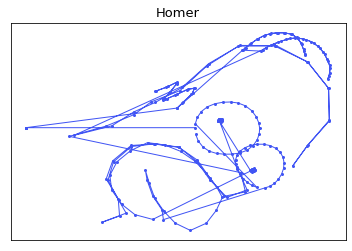

In [172]:
plot("Homer", xs, ys, linestyle="-")

In [175]:
circ

In [179]:
circ.size()

3230

In [183]:
new_circ = transpile(circ, device, optimization_level=1)

In [184]:
new_circ.size()

10969

In [176]:
circ.draw(output='mpl')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f6a8a6d90e0> (for post_execute):


KeyboardInterrupt: 